In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 🏗 Anchor產生器

In [52]:
class AnchorGenerator:
    def __init__(self, img_size=512):
        self.img_size = img_size
        self.feature_map_sizes = [(32, 32), (16, 16)]
        self.base_sizes = [(img_size*0.1, img_size*0.1), (img_size*0.15, img_size*0.15)]

    def generate(self, device=None):
        anchors = []

        for (fm_h, fm_w), (base_w, base_h) in zip(self.feature_map_sizes, self.base_sizes):
            for i in range(fm_h):
                for j in range(fm_w):
                    cx = (j + 0.5) * (self.img_size / fm_w)
                    cy = (i + 0.5) * (self.img_size / fm_h)

                    shapes = [
                        (base_w, base_h),
                        (base_w * 1.5, base_h * 0.5),
                        (base_w * 0.5, base_h * 1.5),
                    ]

                    for w, h in shapes:
                        anchors.append([
                            (cx - w/2) / self.img_size,
                            (cy - h/2) / self.img_size,
                            (cx + w/2) / self.img_size,
                            (cy + h/2) / self.img_size
                        ])

        anchors = torch.tensor(anchors, dtype=torch.float32)
        if device:
            anchors = anchors.to(device)
        return anchors


# 🏗 SSD模型

In [53]:
import torch
import torch.nn as nn

class SSD(nn.Module):
    def __init__(self, num_classes, anchor_generator):
        super(SSD, self).__init__()
        self.num_classes = num_classes
        self.anchor_generator = anchor_generator

        # Backbone
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 512->256
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 256->128
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 128->64
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),# 64->32
            nn.ReLU(),
        )

        # 特徵圖
        self.extra_layer = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), # 32->16
            nn.ReLU()
        )

        # 輸出頭(分類和框)
        self.class_heads = nn.ModuleList([
            nn.Conv2d(256, 3 * num_classes, kernel_size=3, padding=1),  # for feature map 1
            nn.Conv2d(512, 3 * num_classes, kernel_size=3, padding=1)   # for feature map 2
        ])

        self.bbox_heads = nn.ModuleList([
            nn.Conv2d(256, 3 * 4, kernel_size=3, padding=1),  # for feature map 1
            nn.Conv2d(512, 3 * 4, kernel_size=3, padding=1)   # for feature map 2
        ])

    def forward(self, x):
        features = []
        x = self.backbone(x)
        features.append(x)  # Feature Map 1 (32x32)

        x = self.extra_layer(x)
        features.append(x)  # Feature Map 2 (16x16)

        cls_preds = []
        bbox_preds = []

        for feature, cls_head, bbox_head in zip(features, self.class_heads, self.bbox_heads):
            cls_preds.append(cls_head(feature).permute(0, 2, 3, 1).contiguous()) # b h w c
            bbox_preds.append(bbox_head(feature).permute(0, 2, 3, 1).contiguous())

        cls_preds = torch.cat([c.view(c.size(0), -1, self.num_classes) for c in cls_preds], dim=1) # b n c
        bbox_preds = torch.cat([b.view(b.size(0), -1, 4) for b in bbox_preds], dim=1)

        return cls_preds, bbox_preds


# 🎯 損失函數

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Loss(nn.Module):
    def __init__(self, neg_pos_ratio=3):
        super(Loss, self).__init__()
        self.neg_pos_ratio = neg_pos_ratio
        self.cls_loss_fn = nn.CrossEntropyLoss(reduction='none')
        self.reg_loss_fn = nn.SmoothL1Loss(reduction='none')

    def forward(self, cls_preds, bbox_preds, cls_targets, bbox_targets):
        """
        cls_preds: (batch, num_anchors, num_classes)
        bbox_preds: (batch, num_anchors, 4)
        cls_targets: (batch, num_anchors)
        bbox_targets: (batch, num_anchors, 4)
        """

        batch_size = cls_preds.size(0)
        num_anchors = cls_preds.size(1)

        # cls loss
        cls_loss = self.cls_loss_fn(cls_preds.view(-1, cls_preds.size(-1)), cls_targets.view(-1))  # flatten
        cls_loss = cls_loss.view(batch_size, num_anchors)

        # 正樣本mask
        pos_mask = cls_targets > 0


        # bbox loss
        bbox_loss = self.reg_loss_fn(bbox_preds, bbox_targets).sum(dim=-1)  # sum 4個座標誤差
        bbox_loss = bbox_loss * pos_mask.float()  # 只有正樣本要計算回歸

        # Hard Negative
        num_pos = pos_mask.sum(dim=1, keepdim=True)  # (batch, 1)
        num_neg = self.neg_pos_ratio * num_pos  # 每個batch控制負樣本數量

        cls_loss_neg = cls_loss.clone()
        cls_loss_neg[pos_mask] = -float('inf')  # 把正樣本的loss設成-無限大
        _, idx = cls_loss_neg.sort(dim=1, descending=True)
        _, rank = idx.sort(dim=1)

        neg_mask = rank < num_neg


        total_cls_loss = cls_loss[pos_mask].sum() + cls_loss[neg_mask].sum()
        total_bbox_loss = bbox_loss.sum()

        total_loss = (total_cls_loss + total_bbox_loss) / num_pos.sum().clamp(min=1)  # 防止除以0
        return total_loss


# 🔥 IoU計算與Anchor配對

In [55]:
def box_iou(boxes1, boxes2):
    """
    計算兩組boxes的 IoU
    boxes1: (N, 4)
    boxes2: (M, 4)
    return: (N, M)
    """
    area1 = (boxes1[:,2] - boxes1[:,0]) * (boxes1[:,3] - boxes1[:,1])
    area2 = (boxes2[:,2] - boxes2[:,0]) * (boxes2[:,3] - boxes2[:,1])

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # 左上
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # 右下

    wh = (rb - lt).clamp(min=0)
    inter = wh[:,:,0] * wh[:,:,1]

    union = area1[:, None] + area2 - inter
    return inter / union

def match_anchors(anchors, cls_targets_list, bbox_targets_list, iou_threshold=0.5):
    """
    anchors: (num_anchors, 4)
    cls_targets_list: batch內每張圖片的class list
    bbox_targets_list: batch內每張圖片的bbox list
    return:
        batch_cls_targets: (batch, num_anchors)
        batch_bbox_targets: (batch, num_anchors, 4)
    """
    device = anchors.device
    batch_cls_targets = []
    batch_bbox_targets = []


    for cls_targets, bbox_targets in zip(cls_targets_list, bbox_targets_list):
        num_anchors = anchors.size(0)

        bbox_targets = bbox_targets.to(device)
        cls_targets = cls_targets.to(device)

        if bbox_targets.shape[0] == 0:
            # 沒有物件，全部當背景
            cls_target = torch.zeros(num_anchors, dtype=torch.long, device=device)
            bbox_target = torch.zeros(num_anchors, 4, device=device)
        else:
            # 計算IoU
            ious = box_iou(anchors, bbox_targets)  # (num_anchors, num_objects)

            # 找出每個anchor最好的GT
            max_ious, max_ids = ious.max(dim=1)

            # 建立標籤
            cls_target = torch.zeros(num_anchors, dtype=torch.long, device=device)
            cls_target[max_ious > iou_threshold] = cls_targets[max_ids[max_ious > iou_threshold]]

            # 建立回歸目標 (只有配到的anchor才需要學offset)
            matched_gt_boxes = bbox_targets[max_ids]
            bbox_target = encode_bbox(anchors, matched_gt_boxes)

        batch_cls_targets.append(cls_target)
        batch_bbox_targets.append(bbox_target)

    batch_cls_targets = torch.stack(batch_cls_targets)
    batch_bbox_targets = torch.stack(batch_bbox_targets)

    return batch_cls_targets, batch_bbox_targets

def encode_bbox(anchors, gt_boxes):
    """
    把anchor和gt_box轉成回歸偏移量
    anchors: (N,4)
    gt_boxes: (N,4)
    return: (N,4) -> [dx, dy, dw, dh]
    """
    anchors_cx = (anchors[:, 0] + anchors[:, 2]) / 2
    anchors_cy = (anchors[:, 1] + anchors[:, 3]) / 2
    anchors_w = anchors[:, 2] - anchors[:, 0]
    anchors_h = anchors[:, 3] - anchors[:, 1]

    gt_cx = (gt_boxes[:, 0] + gt_boxes[:, 2]) / 2
    gt_cy = (gt_boxes[:, 1] + gt_boxes[:, 3]) / 2
    gt_w = gt_boxes[:, 2] - gt_boxes[:, 0]
    gt_h = gt_boxes[:, 3] - gt_boxes[:, 1]

    eps = 1e-6  # 避免除以0
    dx = (gt_cx - anchors_cx) / (anchors_w + eps)
    dy = (gt_cy - anchors_cy) / (anchors_h + eps)
    dw = torch.log(gt_w / (anchors_w + eps))
    dh = torch.log(gt_h / (anchors_h + eps))

    return torch.stack([dx, dy, dw, dh], dim=1)


# 🗂️ 載入資料集

In [56]:
import os
import json
import torch
from torch.utils.data import Dataset
from PIL import Image

class ShapeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: 資料夾路徑 ('./dataset/train/')
        """
        self.root_dir = root_dir
        self.transform = transform
        self.img_dir = os.path.join(root_dir, "images")
        self.label_dir = os.path.join(root_dir, "labels")
        self.img_list = sorted(os.listdir(self.img_dir))  # 確保順序對齊

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        # 讀取圖片
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        img = Image.open(img_path).convert("RGB")

        # 讀取標籤
        label_filename = self.img_list[idx].replace(".png", ".json")
        label_path = os.path.join(self.label_dir, label_filename)

        with open(label_path, 'r') as f:
            labels = json.load(f)

        cls_targets = []
        bbox_targets = []

        for obj in labels:
            cls_targets.append(obj["class"])
            bbox = obj["bbox"]
            bbox = [coord / 512.0 for coord in bbox]
            bbox_targets.append(bbox)

        cls_targets = torch.tensor(cls_targets, dtype=torch.long)
        bbox_targets = torch.tensor(bbox_targets, dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, cls_targets, bbox_targets


# 🎯 訓練流程

In [57]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

def train():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    train_dataset = ShapeDataset(root_dir='./dataset/train', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

    anchor_generator = AnchorGenerator()
    anchors = anchor_generator.generate(device=device)  # **只生成一次**

    model = SSD(num_classes=3, anchor_generator=anchor_generator)
    model = model.to(device)

    criterion = Loss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    num_epochs = 80
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_num_pos = 0

        for imgs, cls_targets_list, bbox_targets_list in train_loader:
            imgs = imgs.to(device)
            cls_targets_list = [cls.to(device) for cls in cls_targets_list]
            bbox_targets_list = [bbox.to(device) for bbox in bbox_targets_list]

            cls_preds, bbox_preds = model(imgs)
            cls_targets, bbox_targets = match_anchors(anchors, cls_targets_list, bbox_targets_list, iou_threshold=0.3)

            loss = criterion(cls_preds, bbox_preds, cls_targets, bbox_targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            batch_pos = (cls_targets > 0).sum()
            total_num_pos += batch_pos.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")

    torch.save(model.state_dict(), './ssd_shape.pth')

def collate_fn(batch):
    """讓DataLoader支援 variable number of objects"""
    imgs, cls_targets, bbox_targets = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    return imgs, cls_targets, bbox_targets


In [58]:
import random
import numpy as np
random.seed(42)
np.random.seed(42)
train()

Epoch [1/80] Average Loss: 4.5372
Epoch [2/80] Average Loss: 2.7981
Epoch [3/80] Average Loss: 1.5202
Epoch [4/80] Average Loss: 1.2030
Epoch [5/80] Average Loss: 1.1516
Epoch [6/80] Average Loss: 1.0719
Epoch [7/80] Average Loss: 1.0008
Epoch [8/80] Average Loss: 1.0221
Epoch [9/80] Average Loss: 0.9506
Epoch [10/80] Average Loss: 0.9228
Epoch [11/80] Average Loss: 0.8953
Epoch [12/80] Average Loss: 0.9074
Epoch [13/80] Average Loss: 0.8669
Epoch [14/80] Average Loss: 0.8508
Epoch [15/80] Average Loss: 0.8394
Epoch [16/80] Average Loss: 0.8070
Epoch [17/80] Average Loss: 0.7809
Epoch [18/80] Average Loss: 0.7847
Epoch [19/80] Average Loss: 0.7652
Epoch [20/80] Average Loss: 0.7583
Epoch [21/80] Average Loss: 0.7338
Epoch [22/80] Average Loss: 0.7192
Epoch [23/80] Average Loss: 0.7041
Epoch [24/80] Average Loss: 0.7057
Epoch [25/80] Average Loss: 0.7014
Epoch [26/80] Average Loss: 0.6720
Epoch [27/80] Average Loss: 0.6656
Epoch [28/80] Average Loss: 0.6592
Epoch [29/80] Average Loss: 0

# 🎯 推論流程

In [59]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision

def decode_bbox(anchors, bbox_preds):
    """
    將預測的 offset 轉回圖片座標
    """
    anchors_cx = (anchors[:, 0] + anchors[:, 2]) / 2
    anchors_cy = (anchors[:, 1] + anchors[:, 3]) / 2
    anchors_w = anchors[:, 2] - anchors[:, 0]
    anchors_h = anchors[:, 3] - anchors[:, 1]

    dx = bbox_preds[:, 0]
    dy = bbox_preds[:, 1]
    dw = bbox_preds[:, 2]
    dh = bbox_preds[:, 3]

    pred_cx = dx * anchors_w + anchors_cx
    pred_cy = dy * anchors_h + anchors_cy
    pred_w = torch.exp(dw) * anchors_w
    pred_h = torch.exp(dh) * anchors_h

    x1 = pred_cx - pred_w / 2
    y1 = pred_cy - pred_h / 2
    x2 = pred_cx + pred_w / 2
    y2 = pred_cy + pred_h / 2

    return torch.stack([x1, y1, x2, y2], dim=1)

def predict_image(image_path, score_threshold=0.7, iou_threshold=0.1):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    # 推論
    with torch.no_grad():
        cls_preds, bbox_preds = model(img_tensor)

    cls_probs = torch.softmax(cls_preds[0], dim=-1)  # (num_anchors, num_classes)
    bbox_preds = bbox_preds[0]  # (num_anchors, 4)

    # 解碼bbox
    decoded_bboxes = decode_bbox(anchors, bbox_preds)

    # 乘回圖片大小
    decoded_bboxes = decoded_bboxes * img_size

    # 過濾背景類別(假設0是背景)
    scores, labels = cls_probs[:, 1:].max(dim=1)  # (num_anchors,)
    labels = labels + 1
    keep = scores > score_threshold

    scores = scores[keep]
    labels = labels[keep]
    boxes = decoded_bboxes[keep]


    #NMS
    nms_keep = torchvision.ops.nms(boxes, scores, iou_threshold)
    boxes = boxes[nms_keep]
    scores = scores[nms_keep]
    labels = labels[nms_keep]

    class_names = ['background', 'rectangle', 'circle']



    # 畫圖
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    ax = plt.gca()

    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1.item(), y1.item()), (x2-x1).item(), (y2-y1).item(),
                                  linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        class_name = class_names[label.item()]
        ax.text(x1.item(), y1.item(), f'{class_name} {score:.2f}',
                color='white', fontsize=8, backgroundcolor="red")


    plt.axis('off')
    plt.show()


In [60]:
# 參數
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_size = 512
num_classes = 3

# 載入模型
anchor_generator = AnchorGenerator()
model = SSD(num_classes=num_classes, anchor_generator=anchor_generator)
model.load_state_dict(torch.load('./ssd_shape.pth', map_location=device))
model = model.to(device)
model.eval()

# 預先生成anchors
anchors = anchor_generator.generate(device=device)

# 預處理
transform = transforms.Compose([
    transforms.ToTensor()
])

C:\Users\tony1\AppData\Local\Temp\ipykernel_25480\245751055.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./ssd_shape.pth', map_locat

# 🎨 視覺化測試

圖片: ./dataset/val/images\0020.png


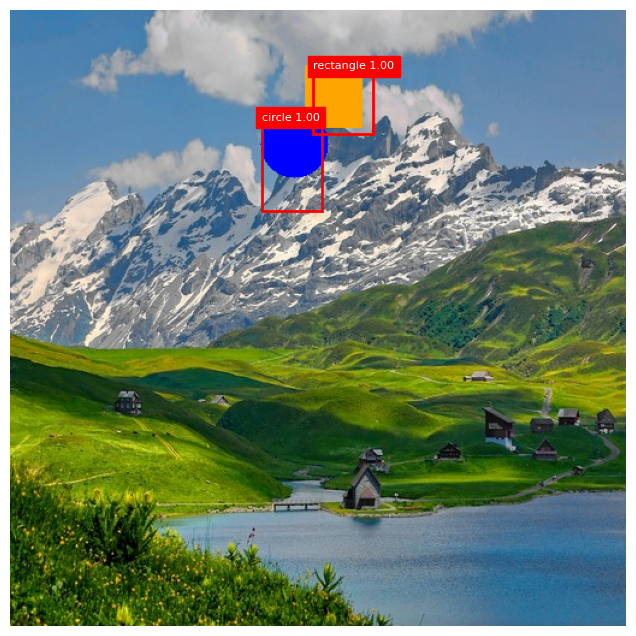

In [61]:
import os
import random

def random_predict_image(val_images_dir='./dataset/val/images', score_threshold=0.7, iou_threshold=0.1):
    img_list = os.listdir(val_images_dir)
    img_list = [f for f in img_list if f.endswith('.png')]
    img_path = os.path.join(val_images_dir, random.choice(img_list))
    print(f"圖片: {img_path}")
    predict_image(img_path, score_threshold=score_threshold, iou_threshold=iou_threshold)

# 測試一張圖片
random_predict_image()


# 🎯 補充：使用驗證集計算 mAP

In [64]:
from torchvision.ops import box_iou
import json
import os
from glob import glob
from collections import defaultdict
import torch
from PIL import Image
import numpy as np

def evaluate(val_img_dir='./dataset/val/images',
                 val_label_dir='./dataset/val/labels',
                 score_threshold=0.3,
                 iou_threshold=0.5):

    all_detections = defaultdict(list)  # cls_id -> list of (image_id, score, box)
    all_annotations = defaultdict(dict)  # cls_id -> image_id -> list of boxes

    img_paths = sorted(glob(os.path.join(val_img_dir, '*.png')))

    for img_path in img_paths:
        image_id = os.path.basename(img_path).replace('.png', '')
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            cls_preds, bbox_preds = model(img_tensor)

        cls_probs = torch.softmax(cls_preds[0], dim=-1)  # (num_anchors, num_classes)
        scores, labels = cls_probs[:, 1:].max(dim=1)  # 跳過背景
        labels += 1
        keep = scores > score_threshold

        boxes = decode_bbox(anchors, bbox_preds[0])[keep] * img_size
        labels = labels[keep]
        scores = scores[keep]

        # NMS
        keep_nms = torch.ops.torchvision.nms(boxes, scores, iou_threshold=0.3)
        boxes = boxes[keep_nms]
        scores = scores[keep_nms]
        labels = labels[keep_nms]

        for box, score, label in zip(boxes, scores, labels):
            all_detections[label.item()].append((image_id, score.item(), box.cpu()))

        # 讀取 GT
        label_path = os.path.join(val_label_dir, image_id + '.json')
        with open(label_path) as f:
            gt = json.load(f)

        for obj in gt:
            cls_id = obj['class']
            bbox = obj['bbox']
            bbox = torch.tensor(bbox, dtype=torch.float32)
            all_annotations[cls_id].setdefault(image_id, []).append(bbox)

    # ---------------------------
    # 計算 AP for 每一類別
    # ---------------------------
    aps = []
    for cls_id in sorted(all_annotations.keys()):
        detections = sorted(all_detections.get(cls_id, []), key=lambda x: -x[1])  # 根據 conf 由高到低
        n_gt = sum(len(v) for v in all_annotations[cls_id].values())
        if n_gt == 0:
            continue

        TP = np.zeros(len(detections))
        FP = np.zeros(len(detections))
        matched = defaultdict(set)  # image_id -> set of matched gt indices

        for i, (image_id, score, pred_box) in enumerate(detections):
            gt_boxes = all_annotations[cls_id].get(image_id, [])
            if len(gt_boxes) == 0:
                FP[i] = 1
                continue

            gt_boxes_tensor = torch.stack(gt_boxes)
            ious = box_iou(pred_box.unsqueeze(0), gt_boxes_tensor)[0]
            max_iou, max_idx = ious.max(0)

            if max_iou >= iou_threshold and max_idx.item() not in matched[image_id]:
                TP[i] = 1
                matched[image_id].add(max_idx.item())
            else:
                FP[i] = 1

        # 累積 TP / FP
        cum_TP = np.cumsum(TP)
        cum_FP = np.cumsum(FP)
        precisions = cum_TP / (cum_TP + cum_FP + 1e-6)
        recalls = cum_TP / n_gt

        # VOC-style AP (11-point)
        ap = 0.0
        for t in np.linspace(0, 1, 11):
            if np.sum(recalls >= t) == 0:
                p = 0
            else:
                p = np.max(precisions[recalls >= t])
            ap += p / 11
        aps.append(ap)

        print(f"Class {cls_id}: AP = {ap:.4f}")

    mAP = np.mean(aps) if aps else 0
    print(f"\nOverall mAP@{iou_threshold}: {mAP:.4f}")


In [65]:
evaluate()

Class 1: AP = 0.8640
Class 2: AP = 0.6101

Overall mAP@0.5: 0.7370
